The following code is the MCMC calibration code for the Heston-Jump model. The code was provided to us by Cape et al whose paper can be found in our references in the main document.  We modified the code to account for the jump parameters. 

In [1]:
BURNIN = 1000  # Burnin period
N = 10000      # number of simulations

# input daily returns. "scan" reads each line of the file, and assigns these values to the vector Y.
Y = scan('DailyData2.txt') 
T = length(Y) - 2

#This would reproduce 'NA' BURNIN+N=2000 times. Here 'NA' means 'not available'. This puts in random values for the first 2000 elements.
mu = rep(NA, BURNIN+N)  
psi = rep(NA, BURNIN+N)
omega = rep(NA, BURNIN+N)
kappa = rep(NA, BURNIN+N)
theta = rep(NA, BURNIN+N)
lambda = rep(NA, BURNIN+N)
mus = rep(NA, BURNIN+N)
sigma2s = rep(NA, BURNIN+N)
epsilons = rep(NA,(BURNIN+N)*T)

#Creates a column matrix ((BURNIN+N) BY 1) of epsilon values in the previous line.
epsilons = matrix(epsilons, BURNIN+N) 
epsilonv = rep(NA,(BURNIN+N)*T)
epsilonv = matrix(epsilonv, BURNIN+N)

# parameter initializations
V = rep(NA,(BURNIN+N)*(T+2))		
V = matrix(V, BURNIN+N)
Z = rep(NA,(BURNIN+N)*(T+2))		
Z = matrix(Z, BURNIN+N)
B = rep(NA,(BURNIN+N)*(T+2))		
B = matrix(B, BURNIN+N)
P = rep(NA,(BURNIN+N)*(T+2))		
P = matrix(P, BURNIN+N)

#Hyperparameters for mu
mustar = rep(NA, BURNIN+N)		
sigstar = rep(NA, BURNIN+N)
mustara = rep(NA, BURNIN+N)
mustarb = rep(NA, BURNIN+N)

#Hyperparameters for psi
psistar = rep(NA, BURNIN+N)			
pstar = rep(NA, BURNIN+N)

#Hyperparameters for omega
alphastar = rep(NA, BURNIN+N)		
betastar = rep(NA, BURNIN+N)
betastara = rep(NA, BURNIN+N)
betastarb = rep(NA, BURNIN+N)

#Hyperparameters for kappa
kappastar = rep(NA, BURNIN+N)		
kappastara = rep(NA, BURNIN+N)
kappastarb = rep(NA, BURNIN+N)
sigmakapstar = rep(NA, BURNIN+N)

#Hyperparameters for theta			
thetastar = rep(NA, BURNIN+N)		
thetastara = rep(NA, BURNIN+N)
thetastarb = rep(NA, BURNIN+N)
sigthstar = rep(NA, BURNIN+N)

#Hyperparameters for lambda
alphalam = rep(NA, BURNIN+N)		
betalam = rep(NA, BURNIN+N)

#Hyperparameters for Z (The jump term)
musstar = rep(NA,(BURNIN+N)*(T+2))	
musstar = matrix(musstar, BURNIN+N)
sigma2sstar = rep(NA,(BURNIN+N)*(T+2))		
sigma2sstar = matrix(sigma2sstar, BURNIN+N)

#Just ended part is for setting random values (NA) to all the variables. 

#Initialize prior hyperparameters
mu0 = 0					
sigma0 = 1
psi0 = 0
p0 = 2
alphatilde0 = 2
betatilde0 = 0.005
kappa0 = 0
sigmakap0 = 1
theta0 = 0
sigmath0 = 1
alphaprime = 2
betaprime = 40
mus0 = 0
S0 = 1
alphas = 5.0
betas = 0.2
deltat=1/252

# Metropolis-Hastings recordings
pi = rep(NA, (BURNIN+N)*(T+2))		
pi = matrix(pi, BURNIN+N)
a = rep(NA,(BURNIN+N)*(T+2))
a = matrix(a, BURNIN+N)
accept = rep(NA, BURNIN+N)

rigamma = function(n, a, b) {
        return(1/rgamma(n, shape = a, rate = b))
    }
# Initialize parameters
mu[1] = 0.1
omega[1]=0.02
psi[1] = rnorm(1, psi0, sqrt(omega[1]/(p0)))
#psi[1]=0
#omega[1] = rigamma(1, alphatilde0, betatilde0)
kappa[1]=5
theta[1]=0.15^2
lambda[1] = rbeta(1, alphaprime, betaprime)
mus[1]=0
#mus[1]=rnorm(1,mus0,sqrt(S0))
sigma2s[1]=0.01
#sigma2s[1]=rigamma(1,alphas,betas)
P[1,] = rep(lambda[1],T+2)
B[1,] = rbinom(T+2,1,lambda[1])
Z[1,] = rep(0,T+2)
INITIALV = 0.15^2
SIGMAN = 0.005
V[1,] = rnorm(T+2,INITIALV, SIGMAN)
		
# Initialize hyperparameters
alphalam[1]=alphaprime                          
betalam[1]=betaprime
musstar[1,] = rep(mus[1],T+2)
sigma2sstar[1,] = rep(sigma2s[1],T+2)

epsilons[1,] = (Y[2:(T+1)] - mu[1]*deltat + 1/2*V[1,1:T]*deltat - Z[1,2:(T+1)]*B[1,2:(T+1)])/sqrt(V[1,1:T]*deltat)
epsilonv[1,] = (V[1,2:(T+1)] - kappa[1]*theta[1]*deltat - (1 - kappa[1]*deltat) * V[1,1:T])/
			sqrt(V[1,1:T]*deltat)

pi[1,] = rep(1,T+2)


for(i in 2:(BURNIN+N)) {		# Beginning of MCMC

					# Update mu hyperparameters
mustara[i] = sum((omega[i-1] + psi[i-1]^2) *(Y[2:(T+1)] + 1/2*V[i-1,1:T]*deltat - Z[i-1,2:(T+1)]*B[i-1,2:(T+1)])/(omega[i-1]*V[i-1,1:T]))

mustarb[i] = sum(psi[i-1]*(V[i-1,2:(T+1)] - kappa[i-1]*theta[i-1]*deltat - 
		(1 - kappa[i-1]*deltat)*V[i-1,1:T])/(omega[i-1]*V[i-1,1:T]))

mustar[i] = (mustara[i]-mustarb[i]+(mu0/sigma0^2))/
		(deltat*sum((omega[i-1] + psi[i-1]^2)/(omega[i-1]*V[i-1,1:T])) + 1/sigma0^2)

sigstar[i] = sqrt(1/(deltat*sum((omega[i-1] + psi[i-1]^2)/(omega[i-1]*V[i-1,1:T])) + 1/sigma0^2))

mu[i] =  rnorm(1,mustar[i],sigstar[i])	# Update mu



alphastar[i] = T/2 + alphatilde0  # Update omega and psi hyperparameters

eps = (Y[2:(T+1)] - mu[i]*deltat + 1/2*V[i-1,1:T]*deltat)/sqrt(V[i-1,1:T]*deltat)

epv = (V[i-1,2:(T+1)] - kappa[i-1]*theta[i-1]*deltat - (1 - kappa[i-1]*deltat) * V[i-1,1:T])/
		sqrt(V[i-1,1:T]*deltat)

pstar[i] = p0 + sum(eps^2)

psistar[i] = (p0*psi0 + sum(eps*epv))/pstar[i]

betastara[i] = (1/2)*sum(epv^2)

betastarb[i] = (p0*psi0 + sum(eps*epv))^2/pstar[i]

#betastar[i] = betatilde0 + betastara[i] + (1/2)*p0*psi0^2 - (1/2)*betastarb[i]

betastar[i] = (betatilde0 + betastara[i] + (1/2)*p0*psi0^2 - (1/2)*betastarb[i])

omega[i] = rigamma(1, alphastar[i], betastar[i])	# Update omega

psi[i] = rnorm(1, psistar[i], sqrt(omega[i]/pstar[i]))	# Update psi

						# Update theta hyperparameters
thetastara[i] = sum(kappa[i-1]*(V[i-1,2:(T+1)] - (1 - kappa[i-1]*deltat)*V[i-1,1:T])/
		(omega[i]*V[i-1,1:T]))

thetastarb[i] = sum(psi[i]*(Y[2:(T+1)] - mu[i]*deltat + (1/2)*V[i-1,1:T]*deltat)*kappa[i-1]/
		(omega[i]*V[i-1,1:T]))

denom = deltat*sum(kappa[i-1]^2/(omega[i]*V[i-1,1:T])) + 1/sigmath0^2

thetastar[i] = (thetastara[i] - thetastarb[i] + theta0/sigmath0^2)/denom

sigthstar[i] = sqrt(1/denom)

#theta[i] = rnorm(1, thetastar[i], sigthstar[i])	# Update theta
u = runif(1,0,1)					# Updating theta using truncated normal
eval = (1 - pnorm(0, thetastar[i], sigthstar[i]))*u + pnorm(0, thetastar[i], sigthstar[i])
theta[i] = qnorm(eval, thetastar[i], sigthstar[i])


						# Update kappa hyperparameters
kappastara[i] = sum((theta[i] - V[i-1,1:T])*(V[i-1,2:(T+1)]-V[i-1,1:T])/
		(omega[i]*V[i-1,1:T]))

kappastarb[i] = sum(psi[i]*(Y[2:(T+1)] - mu[i]*deltat + (1/2)*V[i-1,1:T]*deltat)*(theta[i] - V[i-1,1:T])/
		(omega[i]*V[i-1,1:T]))

denom = deltat*sum((V[i-1,1:T]-theta[i])^2/(omega[i]*V[i-1,1:T])) + 1/sigmakap0^2

kappastar[i] = (kappastara[i] - kappastarb[i] + kappa0/sigmakap0^2)/denom

sigmakapstar[i] = sqrt(1/denom)

#kappa[i] = rnorm(1, kappastar[i], sigmakapstar[i])	# Update kappa
u = runif(1,0,1)					# Updating kappa using truncated normal
eval = (1 - pnorm(0, kappastar[i], sigmakapstar[i]))*u + pnorm(0, kappastar[i], sigmakapstar[i])
kappa[i] = qnorm(eval, kappastar[i], sigmakapstar[i])


V[i,]=rep(-1,T+2)
for(j in 1:(T+2)){
while(V[i,j]<0){
V[i,j] = V[i-1,j] + rnorm(1, 0, SIGMAN)	}}	# Update V - propose new values

count = T+2

epsnew1 = (Y[2] - mu[i]*deltat + 1/2*V[i,1]*deltat)/sqrt(V[i,1]*deltat)

epsold1 = (Y[2] - mu[i]*deltat + 1/2*V[i-1,1]*deltat)/sqrt(V[i-1,1]*deltat)

epvnew1 = (V[i-1,2] - kappa[i]*theta[i]*deltat - (1 - kappa[i]*deltat) * V[i,1])/
		sqrt(V[i,1]*deltat)

epvold1 = (V[i-1,2] - kappa[i]*theta[i]*deltat - (1 - kappa[i]*deltat) * V[i-1,1])/
		sqrt(V[i-1,1]*deltat)

pVnew = (1/(V[i,1]*deltat))*exp(-(1/(2*omega[i]))*((omega[i]+psi[i]^2)*epsnew1^2
		- 2* psi[i]*epsnew1*epvnew1 + epvnew1^2))

pVold = (1/(V[i-1,1]*deltat))*exp(-(1/(2*omega[i]))*((omega[i]+psi[i]^2)*epsold1^2
		- 2* psi[i]*epsold1*epvold1 + epvold1^2))

pi[i,1] = pVnew/pVold

if(V[i,1] <= 0) {
pi[i,1] = 0
}
    
a[i,1] = min(pi[i,1],1)
    
u = runif(1)
if(u > a[i,1]) {
 V[i,1] = V[i-1,1]
 count = count - 1
}


for(j in 2:(T+1)){

epsnew1 = (Y[(j+1)] - mu[i]*deltat + 1/2*V[i,j]*deltat)/sqrt(V[i,j]*deltat)

epsold1 = (Y[(j+1)] - mu[i]*deltat + 1/2*V[i-1,j]*deltat)/sqrt(V[i-1,j]*deltat)

epvnew1 = (V[i-1,(j+1)] - kappa[i]*theta[i]*deltat - (1 - kappa[i]*deltat) * V[i,j])/
		sqrt(V[i,j]*deltat)

epvold1 = (V[i-1,(j+1)] - kappa[i]*theta[i]*deltat - (1 - kappa[i]*deltat) * V[i-1,j])/
		sqrt(V[i-1,j]*deltat)

epsnew0 = (Y[j] - mu[i]*deltat + 1/2*V[i,(j-1)]*deltat)/sqrt(V[i,(j-1)]*deltat)

epsold0 = (Y[j] - mu[i]*deltat + 1/2*V[i,(j-1)]*deltat)/sqrt(V[i,(j-1)]*deltat)

epvnew0 = (V[i,j] - kappa[i]*theta[i]*deltat - (1 - kappa[i]*deltat) * V[i,(j-1)])/
		sqrt(V[i,(j-1)]*deltat)

epvold0 = (V[i-1,j] - kappa[i]*theta[i]*deltat - (1 - kappa[i]*deltat) * V[i,(j-1)])/
		sqrt(V[i,(j-1)]*deltat)

pVnew = (1/(V[i,j]*deltat))*exp(-(1/(2*omega[i]))*((omega[i]+psi[i]^2)*epsnew1^2
		- 2* psi[i]*epsnew1*epvnew1 + epvnew1^2)) *
		exp(-(1/(2*omega[i]))*(-2*psi[i]*epsnew0*epvnew0 + epvnew0^2))

pVold = (1/(V[i-1,j]*deltat))*exp(-(1/(2*omega[i]))*((omega[i]+psi[i]^2)*epsold1^2
		- 2* psi[i]*epsold1*epvold1 + epvold1^2)) *
		exp(-(1/(2*omega[i]))*(-2*psi[i]*epsold0*epvold0 + epvold0^2))

pi[i,j] = pVnew/pVold

	if(V[i,j] <= 0) {
	pi[i,j] = 0
	}
    
	a[i,j] = min(pi[i,j],1)
    
	u = runif(1)
	if(u > a[i,j]) {
 	V[i,j] = V[i-1,j]
 	count = count - 1
	}
}

epsnew0 = (Y[(T+2)] - mu[i]*deltat + 1/2*V[i,(T+1)]*deltat)/sqrt(V[i,(T+1)]*deltat)

epsold0 = (Y[(T+2)] - mu[i]*deltat + 1/2*V[i,(T+1)]*deltat)/sqrt(V[i,(T+1)]*deltat)

epvnew0 = (V[i,(T+2)] - kappa[i]*theta[i]*deltat - (1 - kappa[i]*deltat) * V[i,(T+1)])/
		sqrt(V[i,(T+1)]*deltat)

epvold0 = (V[i-1,(T+2)] - kappa[i]*theta[i]*deltat - (1 - kappa[i]*deltat) * V[i,(T+1)])/
		sqrt(V[i,(T+1)]*deltat)


pVnew = exp(-(1/(2*omega[i]))*(-2*psi[i]*epsnew0*epvnew0 + epvnew0^2))

pVold = exp(-(1/(2*omega[i]))*(-2*psi[i]*epsold0*epvold0 + epvold0^2))


pi[i,(T+2)] = pVnew/pVold

if(V[i,(T+2)] <= 0) {
pi[i,(T+2)] = 0
}
    
a[i,(T+2)] = min(pi[i,(T+2)],1)
    
u = runif(1)
if(u > a[i,(T+2)]) {
V[i,(T+2)] = V[i-1,(T+2)]
count = count - 1
}

accept[i] = count/T
print(i)



musstar[i,1] = mus[i-1]
sigma2sstar[i,1] = sigma2s[i-1]
Z[i,1] = rnorm(1, musstar[i,1], sqrt(sigma2sstar[i,1]))

for (j in 2:(T+2)){			# update Z hyperparameters

musa = (omega[i] + psi[i]^2) *(Y[j] + 1/2*V[i,j-1]*deltat - mu[i]*deltat)/(omega[i]*V[i,j-1]*deltat)

musb = psi[i]*(V[i,j] - kappa[i]*theta[i]*deltat - (1 - kappa[i]*deltat)*V[i,j-1])/(omega[i]*V[i,j-1]*deltat)

musstar[i,j] = (musa*B[i-1,j] - musb*B[i-1,j] + (mus[i-1]/sigma2s[i-1]))/(((omega[i] + psi[i]^2)/(omega[i]*V[i,j-1]*deltat))*B[i-1,j] + 1/sigma2s[i-1])


sigma2sstar[i,j] = 1/(((omega[i] + psi[i]^2)/(omega[i]*V[i,j-1]*deltat))*B[i-1,j] + 1/sigma2s[i-1])

Z[i,j] =  rnorm(1,musstar[i,j],sqrt(sigma2sstar[i,j]))	# Update Z
}


P[i,1] = lambda[i-1]
B[i,1] = rbinom(1, 1, P[i,1])

for(j in 2:(T+2)){			# update B hyperparameters
A = ((omega[i] + psi[i]^2)*(Z[i,j]^2 - 2*Z[i,j]*(Y[j] - mu[i]*deltat + (1/2)*V[i,j-1]*deltat))
	+ 2 *psi[i]*(V[i,j] - kappa[i]*theta[i]*deltat - (1 - kappa[i]*deltat)*V[i,j-1])*Z[i,j])/ (omega[i]*V[i,j-1]*deltat)

P[i,j] = 1/((((1 - lambda[i-1]) *exp((1/2)*A))/(lambda[i-1]))+1)

B[i,j] = rbinom(1, 1, P[i,j])		# update B
}

alphalam[i] = alphaprime + sum(B[i,2:(T+1)])	# update lambda hyperparameters
betalam[i] = betaprime + T - sum(B[i,2:(T+1)])
lambda[i] = rbeta(1, alphalam[i], betalam[i])	# update lambda

musstar2 = sum(Z[i,2:(T+1)]*B[i,2:(T+1)]/sigma2s[i-1])/(1/S0+sum(B[i,2:(T+1)]/sigma2s[i-1]))
sigma2sstar2 = 1/(1/S0+sum(B[i,2:(T+1)]/sigma2s[i-1]))

mus[i] = rnorm(1, musstar2, sqrt(sigma2sstar2))	# update mus

alphastar2 = alphas + sum(B[i,2:(T+1)])/2
betastar2 = betas + (1/2)*sum((Z[i,2:(T+1)]-mus[i])^2*B[i,2:(T+1)])

sigma2s[i] = rigamma(1, alphastar2, betastar2)	# update sigma2s

					# keep track of epsilons

epsilons[i,] = (Y[2:(T+1)] - mu[i]*deltat + 1/2*V[i,1:T]*deltat - Z[i,2:(T+1)]*B[i,2:(T+1)])/sqrt(V[i,1:T]*deltat)
epsilonv[i,] = (V[i,2:(T+1)] - kappa[i]*theta[i]*deltat - (1 - kappa[i]*deltat) * V[i,1:T])/
			sqrt(V[i,1:T]*deltat)


}

rho=psi/sqrt(psi^2+omega)
sigma2v=(psi^2+omega)


[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 139
[1

The results of the algorithm are parameter estimates for CLJ16 (9-day maturity) futures whose data is stored in 'DailyData2.txt'. The same process can be repeated to estimate the parameters for CLM16(21-day maturity) futures, stored in 'DailyData.txt". 

For each parameter we discard the first 3000 runs as a 'burn-in' period. We also the algorithm another 5 times to see if parameter estimates are any different after each run. Finally, based on the methodology described by Cape et al, we performed a bit of sensitivity analysis on the parameters as a test of reliability. In view of this, we 'bumped up' the initial conditions for each parameter to see if this had a considerable effect on the overall values of the parameters.

In our table of estimates, the means and standard deviations are reported since these are best representatives of the corresponding distributions. The parameters determined here are $\mu, \mu_S, \sigma_S, Z, \lambda,\kappa, \theta, \sigma_V,\rho, V.$ 

One thing to keep in mind is that the general methodology is to run the algorithm a number of time (10 times in our case), estimate the parameter of interest in each case and find the mean of that parameter.

For example for $\mu$ the estimates are:

In [39]:
mean(mu[3001:length(mu)])
sd(mu[3001:length(mu)])
#To replicate for other parameters just use 'mean(parameter[3001:length(parameter)]) and sd(parameter[3001:length(parameter)])

[1] -0.116567

[1] 0.1270423

The density plot for $\kappa$ is as follows: 

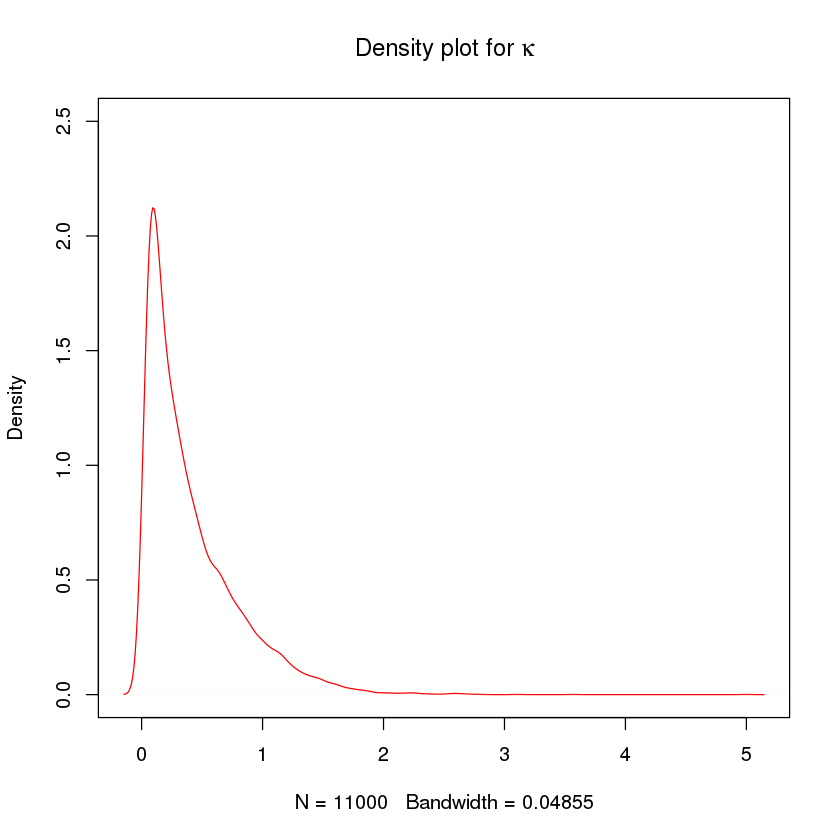

In [40]:
plot(density(kappa), ylim=c(0,2.5), main=expression(paste("Density plot for " ,kappa)), col="red", lwd=1)
#To replicate for other prameters just use plot(density(parameter), ylim=c(0,2.5), main=expression(paste("Density plot for " ,parameter)), col="red", lwd=1)
